In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random

In [2]:
arr = pd.read_csv("phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [3]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]


In [4]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0)
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [5]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]

high_var_w_n = high_var_w.to_numpy()
high_var_n = high_var.to_numpy()

In [6]:
display(high_var.index.values)

array([ 6286, 20893, 19993, ..., 17229,  4611, 21272])

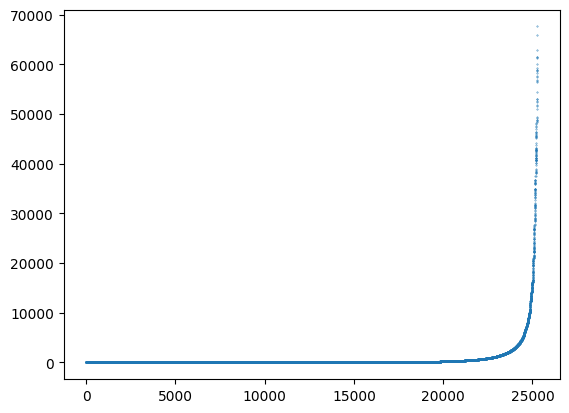

In [7]:
plt.scatter(range(len(var_ex)),sorted(var_ex),s=0.1)

In [8]:
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

len_low_var =low_var.shape[0]

In [9]:
max_removed = 5000

In [10]:
def fitness_batch(ga_instance, solution, solution_idx):
    up = np.add(solution.dot(high_var_w_n),np.tile(low_var_w_sum,(solution.shape[0],1)))
    down = np.add(np.tile(low_var_sum,(solution.shape[0],1)), solution.dot(high_var_n))
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    return - np.var(avgs,axis=1) + (num_not_removed/solution.shape[1]**2*1.e0)
            
    

In [11]:
def fitness(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    
    return - np.var(avgs) + ((sum(solution)/len(solution))**2)*1.e-1
    

In [12]:
def print_curve(solution,label=None):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

In [13]:
def create_population(size):
    return np.array([random.choices([0,1], weights=(1, 30), k=high_var.shape[0]) for _  in range(size)])

In [14]:
pop = create_population(5)
np.sum(pop,axis = 1)

array([24461, 24447, 24469, 24493, 24435])

0.009837646583158657


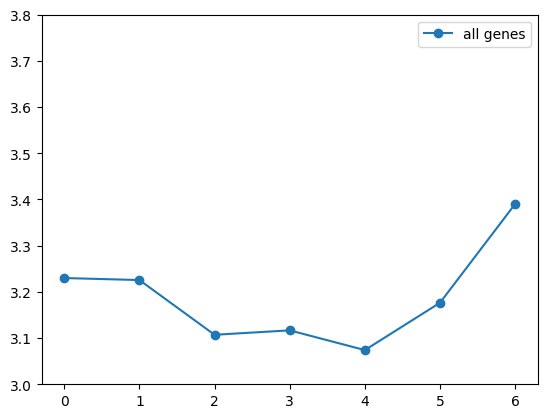

In [15]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [16]:
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)

num_threads = 5
population = create_population(80)

ga_instance = pygad.GA(num_generations=80,
                       num_parents_mating=25,
                       fitness_func=fitness_batch,
                       fitness_batch_size=population.shape[0],
                       initial_population=population,
                       crossover_probability=0.15,
                       mutation_probability=0.003,
                       init_range_low=0,
                       init_range_high=2,
                       gene_type=int,
                       crossover_type="uniform",
                       parallel_processing=["thread", num_threads],
                       save_best_solutions=True,
                       keep_elitism=1,
                       save_solutions=True
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1083: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


6.845383069597197e-06
3621
0.14334916864608077


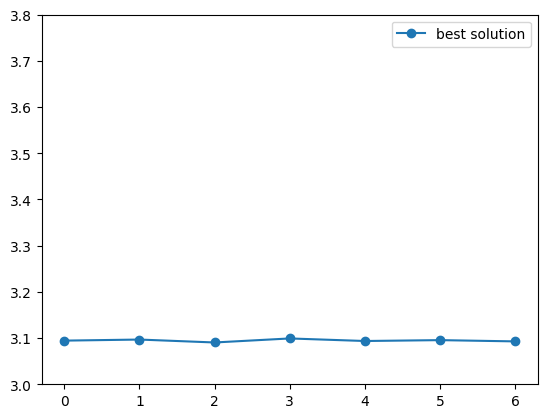

In [17]:
print_curve(solution,label="best solution")
print(len(np.where(solution == 0)[0]))
print(len(np.where(solution == 0)[0])/len(solution))


In [18]:
print(len(set(ga_instance.best_solutions_fitness))/population.shape[0])

print(set(ga_instance.best_solutions_fitness))

0.925
{-0.002057737628471833, -4.856994101346592e-07, -0.0003259365779322827, 2.6318650309694713e-06, -0.0038330770316730677, 1.385819166322374e-05, 2.70679515049833e-05, -5.282567327562976e-05, -0.0065584117709187525, 8.229864445049514e-06, -0.00017450912222598817, -0.0006227375128366372, -0.0015313706689071187, -2.780485553776236e-05, -9.533549307373667e-06, -0.00047934358528594126, -0.0058737086082467525, -0.0009748196582024417, -0.00042922389501419585, -0.0027800627946895514, -0.00013155789542728175, 1.0466792446053104e-05, -5.0356572419016616e-05, 2.318466354579543e-05, 2.5447854649042152e-05, 2.10245024650049e-05, -0.0045448352589428755, -0.004335513416866871, -0.0074805483369281105, -0.0001450894968897218, -1.5487205737058333e-05, 2.1757593828849224e-05, -0.0007689387681353102, 2.4518074132363054e-05, -0.000632784859068513, -3.768208367497195e-05, -0.0016551883044046726, -0.00028112463449173265, 5.534472447858987e-06, 1.6302872354378727e-05, -0.0012394787152894828, -0.0010337738

2.70679515049833e-05


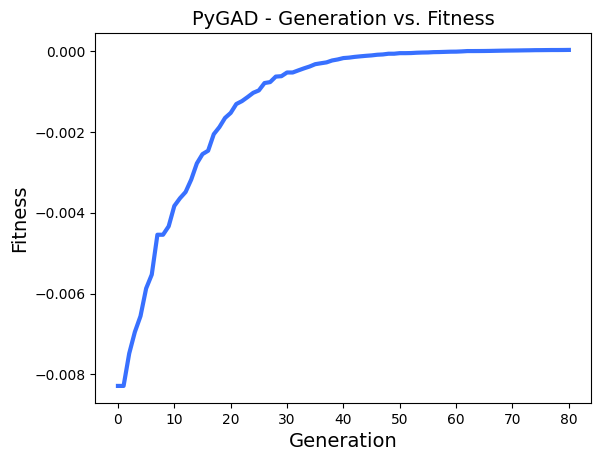

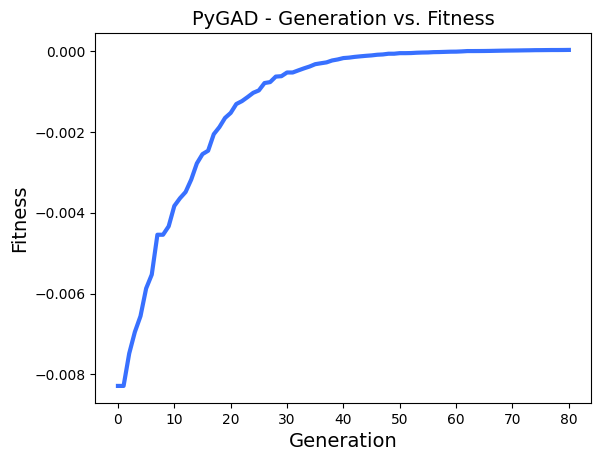

In [19]:
print(solution_fitness)
ga_instance.plot_fitness()

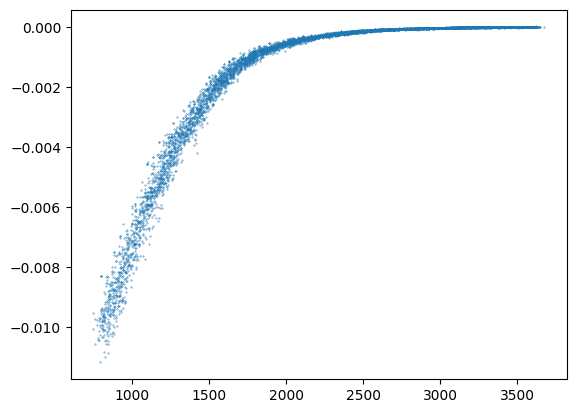

In [20]:

lens = len(solution) - np.sum(np.array(ga_instance.solutions),axis = 1)
fit =fitness_batch(None,np.array(ga_instance.solutions),None)
fit_ind = np.argsort(fitness_batch(None,np.array(ga_instance.solutions),None))
plt.scatter(lens,fit, s=0.1)

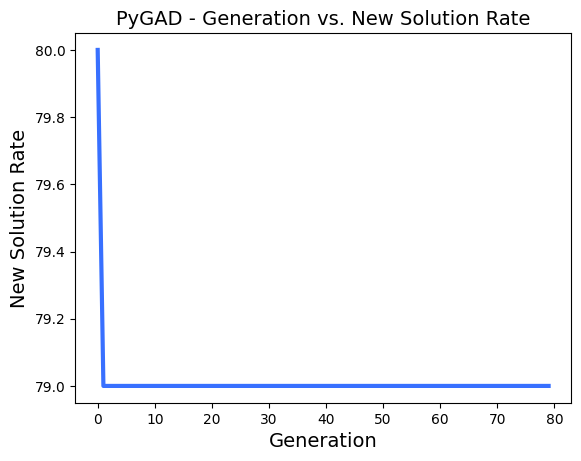

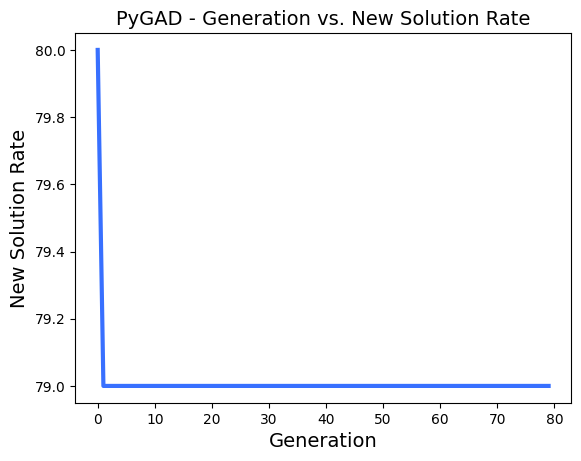

In [21]:
ga_instance.plot_new_solution_rate()

0.008417748874524917


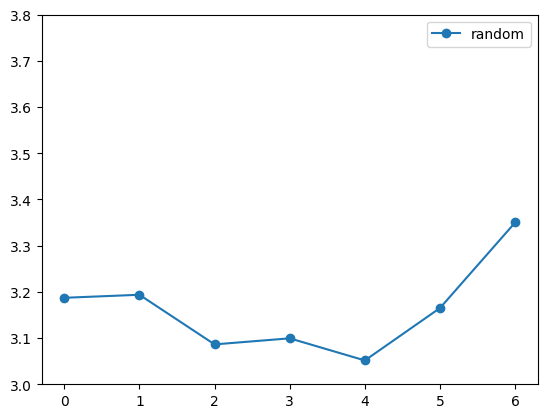

In [24]:
print_curve(np.random.randint(0,2, size=high_var.shape[0]),label="random")

0.009837646583158657


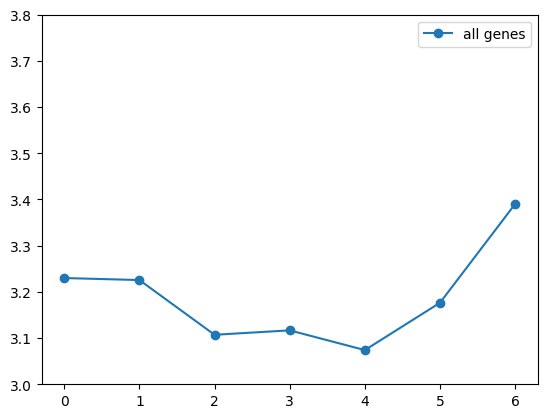

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [25]:

removed_genes =  arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]#["GeneID","Phylostratum"]

In [27]:
display(removed_genes)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
18224,18225,4,at4g21366.1,768.380408,740.386799,744.088334,759.076741,750.359078,760.325575,744.203754
22980,22981,10,at4g10880.1,826.183934,824.239732,823.464727,856.546404,837.380997,836.177490,849.058431
25110,25111,12,at5g48200.1,633.666719,641.580609,664.915666,664.744506,639.427321,647.657121,652.138681
15672,15673,3,at1g22810.1,763.888531,763.118402,784.392299,744.735988,773.588844,760.295925,748.735738
19934,19935,6,at1g14770.1,936.962545,924.842480,927.687180,923.721940,938.745602,908.233810,895.212616
...,...,...,...,...,...,...,...,...,...,...
23539,23540,12,at1g07500.1,2236.167648,872.144043,816.071814,852.034298,824.409176,1904.961405,67841.771130
20470,20471,6,at2g42000.2,1222.490371,965.358396,818.341208,932.676571,985.740730,2320.772865,68712.003370
21446,21447,7,at1g07985.1,2962.440546,904.682744,899.162118,814.911574,784.399822,2371.147397,71635.640930
17229,17230,4,at2g25890.1,2557.845872,995.350743,1369.336359,1164.942882,1116.165097,3608.294510,75420.348310


Text(0, 0.5, 'Frequency')

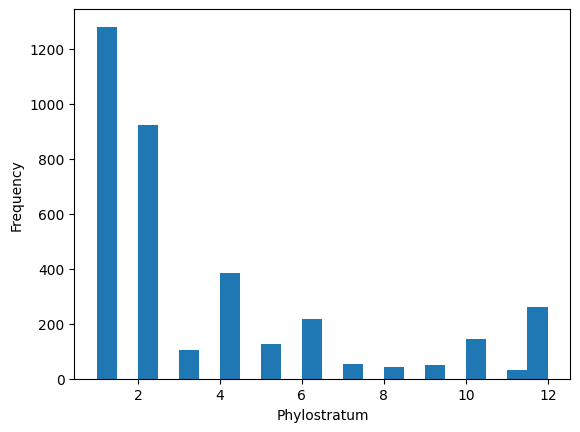

In [31]:
hist, bin_edges = np.histogram(removed_genes["Phylostratum"])
n, bins, patches = plt.hist(x=removed_genes["Phylostratum"], bins='auto')
plt.xlabel('Phylostratum')
plt.ylabel('Frequency')

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_46436/381568176.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)


<AxesSubplot: ylabel='Density'>

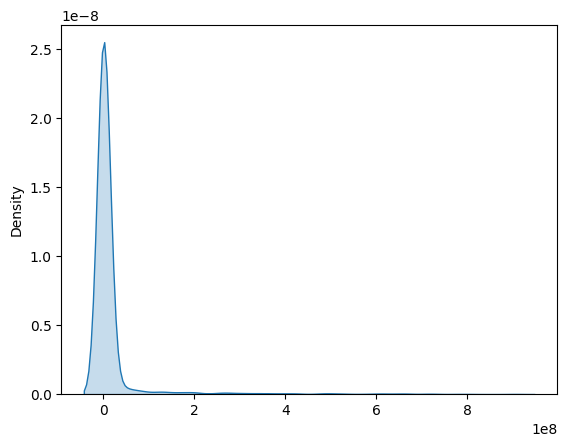

In [39]:
variances = removed_genes.iloc[:, 2:].var(axis=1)
import seaborn as sns
sns.kdeplot(variances, fill=True)